In [21]:
import time
import random
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Configurasi


In [22]:
# --- Pengaturan Simulasi ---
SAMPLING_INTERVAL_MS = 100  # Interval sampling dalam milidetik
TOTAL_DURATION_S = 10       # Total durasi sampling dalam detik

# Konversi interval ke detik
SAMPLING_INTERVAL_S = SAMPLING_INTERVAL_MS / 1000.0

# Hitung jumlah total sampel yang akan diambil
NUM_SAMPLES = int(TOTAL_DURATION_S / SAMPLING_INTERVAL_S)

# Nama file output
OUTPUT_FILENAME = 'sensor_data_simulasi4.csv'
GRAPH_FILENAME = 'sensor_data_graph1.png'


In [23]:
# --- Fungsi Simulasi Pembacaan Sensor ---
def read_simulated_sensor():
    """Mensimulasikan pembacaan data dari sensor.
    
    Dalam skenario nyata, fungsi ini akan berisi kode untuk 
    berinteraksi dengan hardware (misalnya, melalui port serial 
    atau I2C) dan mengembalikan nilai sebenarnya.
    
    Untuk simulasi, kita mengembalikan nilai acak antara 20.00 dan 30.00.
    """
    # Mensimulasikan data sensor, misalnya suhu
    simulated_value = 10 + (random.random() * 5) 
    return round(simulated_value, 1)

In [24]:
# Konversi interval ke detik
SAMPLING_INTERVAL_S = SAMPLING_INTERVAL_MS / 1000.0
# Hitung jumlah total sampel yang akan diambil
NUM_SAMPLES = int(TOTAL_DURATION_S / SAMPLING_INTERVAL_S)

# --- Fungsi Simulasi Pembacaan Sensor ---
def read_simulated_sensor():
    """Mengembalikan nilai acak antara 20.00 dan 30.00."""
    simulated_value = 10 + (random.random() * 5) 
    return round(simulated_value, 1)


In [25]:
# --- FASE 1: Sampling dan Penyimpanan CSV ---
def run_sampling_and_save():
    print(f"--- FASE 1: Sampling Dimulai ---")
    data_samples = []
    start_time = time.time()

    for i in range(NUM_SAMPLES):
        sensor_value = read_simulated_sensor()
        elapsed_time = time.time() - start_time
        
        # Simpan data: [Waktu Relatif (s), Nilai Sensor]
        data_samples.append([round(elapsed_time, 3), sensor_value])
        
        # Tampilkan di konsol (opsional)
        # print(f"Sampel {i+1}: Waktu = {round(elapsed_time, 3)} s, Nilai = {sensor_value}")
        
        # Jeda waktu untuk mencapai interval sampling yang diinginkan
        time.sleep(SAMPLING_INTERVAL_S)

    print(f"Sampling Selesai. Total {len(data_samples)} sampel diambil.")

    # Menyimpan Data ke File CSV
    try:
        with open(OUTPUT_FILENAME, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Waktu Relatif (s)', 'Nilai Sensor'])
            writer.writerows(data_samples)
        print(f"Sukses! Data disimpan ke '{OUTPUT_FILENAME}'")
        return True
    except IOError:
        print(f"ERROR: Gagal menulis ke file '{OUTPUT_FILENAME}'.")
        return False

In [26]:
def create_plot():
    print(f"\n--- FASE 2: Pembuatan Grafik Dimulai ---")
    try:
        # Baca file CSV
        df = pd.read_csv(OUTPUT_FILENAME)
        
        # Buat plot garis
        plt.figure(figsize=(10, 6))
        
        time_col = 'Waktu Relatif (s)'
        value_col = 'Nilai Sensor'
        
        # Plot data
        plt.plot(df[time_col], df[value_col], marker='o', linestyle='-', markersize=3, linewidth=1.5, color='darkgreen')
        
        # Tambahkan judul dan label
        plt.title('Simulasi Pembacaan Sensor (100 ms selama 10s)', fontsize=14)
        plt.xlabel('Waktu Relatif (s)', fontsize=12)
        plt.ylabel('Nilai Sensor (Simulasi)', fontsize=12)
        
        # Pengaturan tambahan untuk kejelasan
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.xticks(np.arange(0, TOTAL_DURATION_S + 1, 1)) # Tanda x setiap 1 detik
        
        # Simpan gambar
        plt.savefig(GRAPH_FILENAME)
        plt.close()
        
        print(f"Sukses! Grafik disimpan sebagai '{GRAPH_FILENAME}'")

    except FileNotFoundError:
        print(f"ERROR: File '{OUTPUT_FILENAME}' tidak ditemukan. Pastikan FASE 1 berjalan dengan sukses.")
    except Exception as e:
        print(f"ERROR saat membuat grafik: {e}")

In [27]:

if run_sampling_and_save():
    create_plot()

print("\n--- Program Selesai ---")

--- FASE 1: Sampling Dimulai ---
Sampling Selesai. Total 100 sampel diambil.
Sukses! Data disimpan ke 'sensor_data_simulasi4.csv'

--- FASE 2: Pembuatan Grafik Dimulai ---
Sukses! Grafik disimpan sebagai 'sensor_data_graph1.png'

--- Program Selesai ---


Data: N=100, t∈[0.000,9.922] dari CSV: /home/wgg/proyek-jupyter/Adaptive-Sampling/sensor_data_simulasi4.csv
Budget sampel: 30
DDS      → MSE=2.428567  MAE=1.174951  n=26
SRS      → MSE=2.584608  MAE=1.075995  n=30
Systemat → MSE=2.587398  MAE=1.116450  n=30


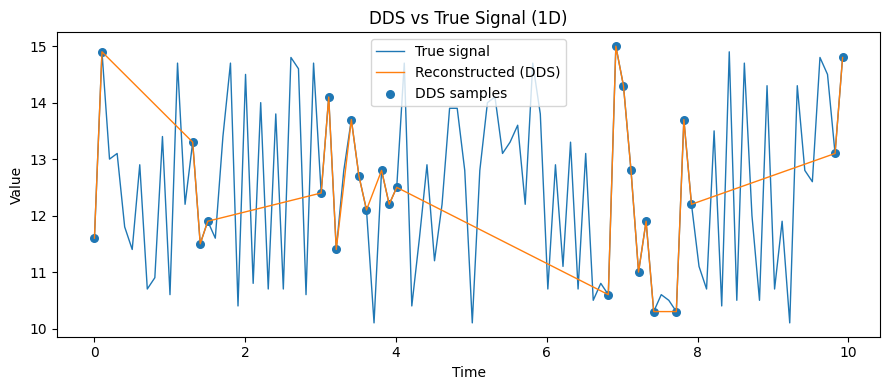

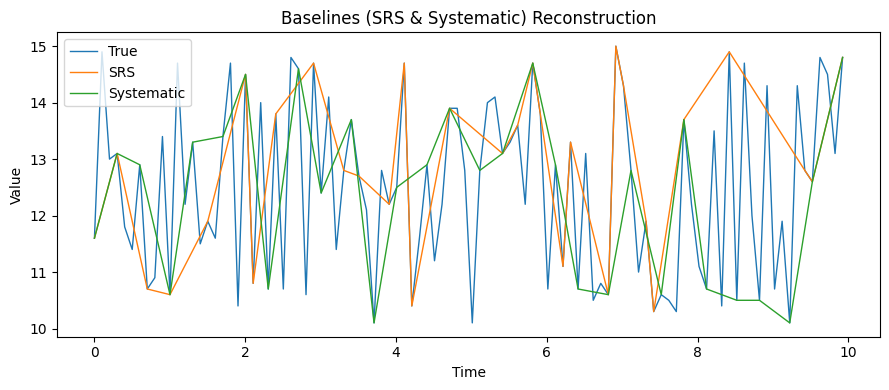

In [28]:
# %% [markdown]
# ## Data‑Driven Adaptive Sampling (DDS) untuk **1D time series**
# 
# **Konteks:** file CSV Anda berisi **dua kolom** — waktu dan nilai sensor — bukan grid 2D. Kode ini mensimulasikan
# DDS pada sinyal 1D: memilih titik pengukuran secara adaptif untuk meminimalkan galat rekonstruksi sinyal.
# 
# **Fitur utama:**
# - Deteksi otomatis kolom waktu & nilai (fallback bila hanya 1 kolom nilai).
# - DDS berbasis **delta residual** terhadap **interpolasi linier lokal** dari titik yang sudah tersampel.
# - Ambang adaptif **median + ALPHA·MAD** dari residual yang teramati.
# - Perbandingan dengan **SRS** (acak) dan **Systematic** (teratur) pada **budget** sama.
# - Metrik: **MSE rekonstruksi** dan **MAE** terhadap sinyal asli.
# - Visualisasi titik sampel di atas kurva.
# 
# **Catatan:** Tidak memakai seaborn, plotting dengan matplotlib.

# %%
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from statistics import median
from typing import Tuple

# ============== KONFIGURASI ==============
CSV_PATH     = "/home/wgg/proyek-jupyter/Adaptive-Sampling/sensor_data_simulasi4.csv"  # ganti bila perlu
TOTAL_BUDGET = 30      # total titik sampel (termasuk seed)
INIT_N       = 10      # jumlah seed SRS awal
ALPHA        = 1.0     # ambang adaptif: median(residual) + ALPHA * MAD
EXPLORE_EPS  = 0.05    # epsilon-greedy eksplorasi
RANDOM_SEED  = 20251012

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ============== UTILITAS DATA ==============

def load_timeseries_from_csv(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Baca CSV menjadi (t, y) sebagai array 1D float.
    Deteksi otomatis:
      - Jika ada >=2 kolom numerik → kolom pertama = waktu, kedua = nilai.
      - Jika hanya 1 kolom numerik → index (0..N-1) jadi waktu, kolom itu jadi nilai.
    """
    df = pd.read_csv(path)
    # pilih kolom numerik saja
    num = df.select_dtypes(include=[float, int])
    if num.shape[1] >= 2:
        t = num.iloc[:, 0].to_numpy(dtype=float)
        y = num.iloc[:, 1].to_numpy(dtype=float)
    elif num.shape[1] == 1:
        y = num.iloc[:, 0].to_numpy(dtype=float)
        t = np.arange(len(y), dtype=float)
    else:
        # tidak ada kolom numerik, coba konversi paksa 2 kolom pertama
        df2 = df.iloc[:, :2].apply(pd.to_numeric, errors='coerce')
        if df2.shape[1] == 0:
            raise ValueError("CSV tidak memiliki kolom numerik yang dapat dibaca.")
        if df2.shape[1] == 1:
            y = df2.iloc[:, 0].fillna(method='ffill').fillna(method='bfill').to_numpy(dtype=float)
            t = np.arange(len(y), dtype=float)
        else:
            t = df2.iloc[:, 0].fillna(method='ffill').fillna(method='bfill').to_numpy(dtype=float)
            y = df2.iloc[:, 1].fillna(method='ffill').fillna(method='bfill').to_numpy(dtype=float)
    # bersihkan NaN simplistik
    if np.isnan(t).any():
        # fallback ke index
        t = np.arange(len(t), dtype=float)
    if np.isnan(y).any():
        # isi dengan median
        med = np.nanmedian(y)
        y = np.where(np.isnan(y), med, y)
    # pastikan urut naik di t
    order = np.argsort(t)
    t = t[order]
    y = y[order]
    return t, y

# Interpolasi linier penuh dari sampel terpilih

def reconstruct_linear(t: np.ndarray, y: np.ndarray, sampled_idx: np.ndarray) -> np.ndarray:
    sampled_idx = np.unique(np.clip(sampled_idx, 0, len(t)-1))
    sampled_idx.sort()
    # pastikan ujung-ujung selalu ada untuk stabilitas
    if sampled_idx[0] != 0:
        sampled_idx = np.concatenate([[0], sampled_idx])
    if sampled_idx[-1] != len(t)-1:
        sampled_idx = np.concatenate([sampled_idx, [len(t)-1]])
    ts = t[sampled_idx]
    ys = y[sampled_idx]
    # np.interp: piecewise linear
    yhat = np.interp(t, ts, ys)
    return yhat

# Prediksi lokal untuk satu titik j dengan dua tetangga tersampel terdekat kiri/kanan

def local_linear_pred(t, y, sampled_set, j):
    # cari tetangga kiri & kanan dalam sampled_set
    left = max([i for i in sampled_set if i < j], default=None)
    right = min([i for i in sampled_set if i > j], default=None)
    if left is None and right is None:
        return np.nan  # tidak bisa prediksi
    if left is None:
        return y[right]
    if right is None:
        return y[left]
    # interpolasi linier
    if t[right] == t[left]:
        return y[left]
    w = (t[j] - t[left]) / (t[right] - t[left])
    return (1 - w) * y[left] + w * y[right]

# MAD

def mad(arr):
    m = median(arr)
    return median([abs(a - m) for a in arr]) if len(arr) > 1 else 0.0

# ============== MUAT DATA ==============

t, y = load_timeseries_from_csv(CSV_PATH)
N = len(t)
print(f"Data: N={N}, t∈[{t[0]:.3f},{t[-1]:.3f}] dari CSV: {CSV_PATH}")

# ============== DDS (1D) ==============

budget = min(TOTAL_BUDGET, N)
init_n = min(INIT_N, budget)

# seed SRS + pastikan ujung masuk
all_idx = np.arange(N)
seed = np.random.choice(all_idx[1:-1], size=max(0, init_n-2), replace=False) if N > 2 else np.array([], dtype=int)
seed = np.unique(np.concatenate(([0], seed, [N-1]))).astype(int)

sampled = set(int(i) for i in seed)
frontier = set()
for i in sampled:
    if i-1 >= 0: frontier.add(i-1)
    if i+1 < N: frontier.add(i+1)
frontier -= sampled

residuals = []

while len(sampled) < budget and len(frontier) > 0:
    # threshold adaptif dari residual yang sudah ada
    thr = (median(residuals) + ALPHA * mad(residuals)) if residuals else float('inf')

    # evaluasi kandidat frontier
    best_j, best_res = None, -1.0
    for j in list(frontier):
        y_pred = local_linear_pred(t, y, sampled, j)
        if np.isnan(y_pred):
            continue
        res = abs(y[j] - y_pred)
        if res > best_res:
            best_res = res
            best_j = j

    if best_j is None:
        # tak ada kandidat dengan prediksi → eksplorasi acak
        cand = list(set(all_idx) - sampled)
        if not cand: break
        pick = int(np.random.choice(cand))
        sampled.add(pick)
    else:
        # eksploitasi jika di atas threshold, selain itu epsilon-greedy
        if best_res >= thr or random.random() < EXPLORE_EPS:
            sampled.add(best_j)
        else:
            sampled.add(random.choice(list(frontier)))

    # update frontier & residuals
    i = list(sampled)[-1]
    if i-1 >= 0: frontier.add(i-1)
    if i+1 < N: frontier.add(i+1)
    frontier -= sampled

    # update residual dari titik terakhir (jika bisa)
    y_pred = local_linear_pred(t, y, sampled - {i}, i)
    if not np.isnan(y_pred):
        residuals.append(abs(y[i] - y_pred))

sampled_idx = np.array(sorted(sampled))

# rekonstruksi & metrik
yhat_dds = reconstruct_linear(t, y, sampled_idx)

mse_dds = float(np.mean((yhat_dds - y) ** 2))
mae_dds = float(np.mean(np.abs(yhat_dds - y)))

# ============== BASELINES ==============
# SRS dengan budget sama
srs_idx = np.random.choice(all_idx[1:-1], size=max(0, budget-2), replace=False) if N > 2 else np.array([], dtype=int)
srs_idx = np.unique(np.concatenate(([0], srs_idx, [N-1]))).astype(int)

yhat_srs = reconstruct_linear(t, y, srs_idx)
mse_srs = float(np.mean((yhat_srs - y) ** 2))
mae_srs = float(np.mean(np.abs(yhat_srs - y)))

# Systematic dengan budget sama
sys_idx = np.linspace(0, N-1, num=budget, dtype=int)
# pastikan unik & urut
sys_idx = np.unique(sys_idx)
if sys_idx[0] != 0:
    sys_idx = np.concatenate([[0], sys_idx])
if sys_idx[-1] != N-1:
    sys_idx = np.concatenate([sys_idx, [N-1]])

yhat_sys = reconstruct_linear(t, y, sys_idx)
mse_sys = float(np.mean((yhat_sys - y) ** 2))
mae_sys = float(np.mean(np.abs(yhat_sys - y)))

print("Budget sampel:", budget)
print(f"DDS      → MSE={mse_dds:.6f}  MAE={mae_dds:.6f}  n={len(sampled_idx)}")
print(f"SRS      → MSE={mse_srs:.6f}  MAE={mae_srs:.6f}  n={len(srs_idx)}")
print(f"Systemat → MSE={mse_sys:.6f}  MAE={mae_sys:.6f}  n={len(sys_idx)}")

# ============== PLOT ==============
plt.figure(figsize=(9,4))
plt.plot(t, y, lw=1, label='True signal')
plt.plot(t, yhat_dds, lw=1, label='Reconstructed (DDS)')
plt.scatter(t[sampled_idx], y[sampled_idx], s=30, label='DDS samples')
plt.title("DDS vs True Signal (1D)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
plt.plot(t, y, lw=1, label='True')
plt.plot(t, yhat_srs, lw=1, label='SRS')
plt.plot(t, yhat_sys, lw=1, label='Systematic')
plt.title("Baselines (SRS & Systematic) Reconstruction")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

# ============== CATATAN ==============
# - DDS memilih titik yang paling menyimpang dari interpolasi lokal saat ini (residual besar),
#   sehingga cenderung menaruh lebih banyak sampel pada segmen sinyal yang berubah cepat.
# - Ubah TOTAL_BUDGET/INIT_N/ALPHA/EXPLORE_EPS untuk melihat trade-off eksplorasi vs eksploitasi.
# - Untuk evaluasi yang lebih ketat, bungkus ini dalam loop Monte Carlo (ulang 50–100x) dan
#   bandingkan distribusi MSE DDS vs baseline pada budget yang sama.

# %% [markdown]
# # Adaptive Cluster Sampling (ACS) untuk Data **3D** (x, y, kedalaman)
#
# **Kapan perlu variabel kedalaman?**
# Jika kualitas air bervariasi terhadap kedalaman, maka **ya**, tambahkan dimensi `z` (kedalaman) ke field Anda
# agar ACS bisa memperluas jaringan secara **vertikal** juga, bukan hanya horizontal di permukaan.
#
# **Inti perubahan dari 2D → 3D:**
# - Representasi data sebagai grid 3D: `grid[r, c, z]`.
# - Neighbor 3D (default 6-neigh): atas/bawah/kiri/kanan/depan/belakang, bisa dinaikkan ke 26-neigh.
# - Network dibangun pada komponen terkoneksi 3D yang mengandung minimal satu sel memenuhi threshold.
# - Estimator **Horvitz–Thompson** level network: \(\hat{\mu} = \frac{1}{N} \sum_{k\in S_*} T_k/\pi_k\), \(\pi_k = 1-(1-m_k/N)^{n0}\).
# - `N = H*W*D`, `m_k` = ukuran network ke-k (jumlah voxel).
#
# **Masukan data:**
# - Langsung sebagai `numpy.ndarray` 3D, atau
# - CSV long-format: kolom `row, col, depth, value` (alias didukung: `r/i`, `c/j`, `z/depth`, `value/val`).
#
# **Catatan:** untuk desain campuran, Anda bisa **stratifikasi berdasarkan kedalaman** (ACS per-layer) lalu gabung dengan bobot ukuran layer.
# %%

D (level kedalaman) = 100, N = 100
Threshold (q=0.90) = 29.310000
Pop. mean (profil) = 24.927000
Mode: acs1d_ht | Est. mean: 24.927000 | Sample size: 100
Baseline SRS mean (n0=10): 23.790000


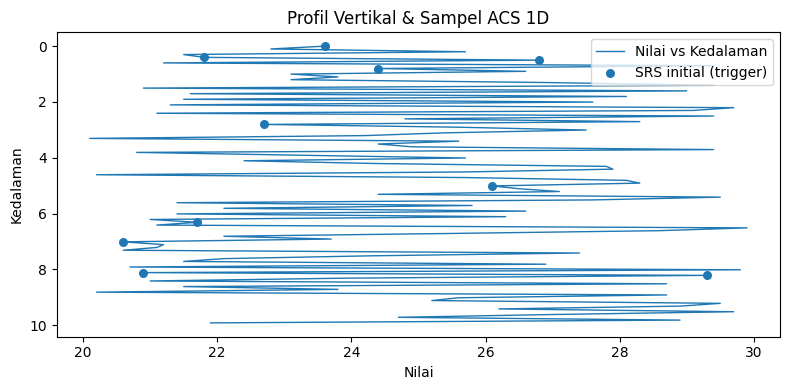

In [29]:
# %% [markdown]
# # Adaptive Cluster Sampling (ACS) **1D Vertikal** — Kedalaman Saja
# 
# **Use case:** Pemantauan kualitas air hanya sepanjang **kedalaman (z)** tanpa dimensi x/y.
# 
# **Ide:**
# - Representasikan profil kedalaman sebagai vektor 1D `v[z]`.
# - Definisikan tetangga 1D: `z-1` dan `z+1`.
# - Network = komponen terkoneksi 1D yang **mengandung setidaknya satu** titik memenuhi kondisi (≥ threshold).
# - Estimator **Horvitz–Thompson** berbasis network: \( \hat{\mu} = \frac{1}{N} \sum_{k \in S_*} T_k/\pi_k \) dengan \( \pi_k = 1 - (1 - m_k/N)^{n0} \).
# - `N = D` (jumlah level kedalaman), `m_k` = ukuran network ke-k.
# 
# **Input yang didukung:**
# - CSV long-format dua kolom: `depth, value` (alias kedalaman/z dan nilai)
# - Atau langsung array numpy 1D.
# 
# **Output:**
# - Estimasi mean populasi (profile rata-rata sepanjang kedalaman) dengan ACS vs SRS baseline
# - Visualisasi profil dan titik terobservasi

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import deque

# ============= KONFIGURASI =============
USE_CSV = True
CSV_PATH = "/home/wgg/proyek-jupyter/Adaptive-Sampling/sensor_data_simulasi3.csv"  # ganti bila perlu
N0 = 10                          # ukuran SRS awal
THRESHOLD_QUANTILE = 0.90        # threshold ditentukan dari kuantil nilai profil
RANDOM_SEED = 123

np.random.seed(RANDOM_SEED)

# ============= MUAT DATA =============

def load_profile_from_csv(path: str):
    df = pd.read_csv(path)
    # alias kolom
    a_dep = {"depth","kedalaman","z"}
    a_val = {"value","nilai","val","v"}
    dep_col = None; val_col = None
    for c in df.columns:
        lc = str(c).strip().lower()
        if lc in a_dep and dep_col is None: dep_col = c
        if lc in a_val and val_col is None: val_col = c
    if dep_col is None or val_col is None:
        # fallback: ambil dua kolom numerik pertama
        num = df.select_dtypes(include=[float, int])
        if num.shape[1] < 2:
            raise ValueError("CSV harus memiliki kolom depth dan value (atau minimal dua kolom numerik).")
        dep = num.iloc[:,0].to_numpy(dtype=float)
        val = num.iloc[:,1].to_numpy(dtype=float)
    else:
        dep = pd.to_numeric(df[dep_col], errors='coerce').to_numpy(dtype=float)
        val = pd.to_numeric(df[val_col], errors='coerce').to_numpy(dtype=float)
    # bersihkan
    m_dep = np.isnan(dep)
    m_val = np.isnan(val)
    m = m_dep | m_val
    dep = dep[~m]; val = val[~m]
    # urut menurut kedalaman (kecil → besar)
    order = np.argsort(dep)
    dep = dep[order]; val = val[order]
    return dep, val

if USE_CSV:
    depth, values = load_profile_from_csv(CSV_PATH)
else:
    # contoh sintetis 1D
    depth = np.linspace(0, 50, 101)
    values = 7 + 0.02*depth + 2.5*np.exp(-((depth-15)**2)/(2*4**2)) + 3.0*np.exp(-((depth-35)**2)/(2*3.5**2))
    values += np.random.normal(0, 0.1, size=values.size)

D = len(depth)
N = D

# Untuk ACS, kita bekerja di indeks 0..D-1; threshold berdasarkan kuantil nilai
thr = float(np.quantile(values, THRESHOLD_QUANTILE))

@dataclass
class ACS1DConfig:
    n0: int
    threshold: float

class ACSSampler1D:
    def __init__(self, arr: np.ndarray, cfg: ACS1DConfig):
        self.arr = np.asarray(arr, dtype=float)
        self.D = len(self.arr)
        self.cfg = cfg
        self.N = self.D

    def build_networks(self):
        qualifies = self.arr >= self.cfg.threshold
        visited = np.zeros(self.D, dtype=bool)
        network_id = -np.ones(self.D, dtype=int)
        networks = {}
        nid = 0
        for i in range(self.D):
            if visited[i]:
                continue
            # telusuri komponen konektivitas 1D (tetangga i-1, i+1)
            comp = []
            q = deque([i]); visited[i] = True
            has_seed = bool(qualifies[i])
            while q:
                u = q.popleft()
                comp.append(u)
                for v in (u-1, u+1):
                    if 0 <= v < self.D and not visited[v]:
                        visited[v] = True
                        q.append(v)
                        if qualifies[v]:
                            has_seed = True
            if has_seed:
                networks[nid] = comp.copy()
                for u in comp: network_id[u] = nid
                nid += 1
            else:
                for u in comp: network_id[u] = -1
        return network_id, networks

    def sample(self):
        network_id, networks = self.build_networks()
        all_idx = np.arange(self.N)
        n0 = min(self.cfg.n0, self.N)
        initial = np.random.choice(all_idx, size=n0, replace=False)
        picked = set()
        for i in initial:
            nid = int(network_id[i])
            if nid != -1:
                picked.add(nid)
        if len(picked) == 0:
            # fallback: mean SRS awal
            est = float(np.mean(self.arr[initial]))
            return {
                "mode":"fallback_to_srs",
                "est_mean": est,
                "sample_size": int(n0),
                "initial_indices": initial.tolist(),
                "picked_networks": []
            }
        HT = 0.0
        observed = set(initial.tolist())
        for nid in picked:
            idxs = networks[nid]
            m_k = len(idxs)
            T_k = float(np.sum(self.arr[idxs]))
            pi_k = 1.0 - (1.0 - (m_k/self.N))**n0
            HT += T_k / pi_k
            for j in idxs: observed.add(int(j))
        est_mean = HT / self.N
        return {
            "mode":"acs1d_ht",
            "est_mean": float(est_mean),
            "sample_size": len(observed),
            "initial_indices": list(map(int, initial)),
            "picked_networks": sorted(list(picked))
        }

acs_cfg = ACS1DConfig(n0=N0, threshold=thr)
acs = ACSSampler1D(values, acs_cfg)
res = acs.sample()

pop_mean = float(np.mean(values))
print(f"D (level kedalaman) = {D}, N = {N}")
print(f"Threshold (q={THRESHOLD_QUANTILE:.2f}) = {thr:.6f}")
print(f"Pop. mean (profil) = {pop_mean:.6f}")
print("Mode:", res["mode"], "| Est. mean:", f"{res['est_mean']:.6f}", "| Sample size:", res["sample_size"])

# Baseline SRS dengan n0 yang sama (untuk referensi cepat)
initial = np.array(res.get("initial_indices", []), dtype=int)
if initial.size == 0:
    initial = np.random.choice(np.arange(N), size=min(N0,N), replace=False)
mean_srs = float(np.mean(values[initial]))
print(f"Baseline SRS mean (n0={len(initial)}): {mean_srs:.6f}")

# Visualisasi profil & titik observasi ACS (network yang terambil)
plt.figure(figsize=(8,4))
plt.plot(values, depth, lw=1, label='Nilai vs Kedalaman')
plt.gca().invert_yaxis()  # kedalaman makin ke bawah
# titik observed (aproksimasi: gabungkan initial + network terpilih)
obs_idx = set(initial.tolist())
for nid in res.get("picked_networks", []):
    pass  # sudah ditambahkan di sample_size; untuk plot minimum tampilkan initial
plt.scatter(values[initial], depth[initial], s=30, label='SRS initial (trigger)')
plt.xlabel('Nilai')
plt.ylabel('Kedalaman')
plt.title('Profil Vertikal & Sampel ACS 1D')
plt.legend()
plt.tight_layout()
plt.show()
